In [1]:
import numpy as np 
import numpy                          
import matplotlib.pyplot as plt
%matplotlib notebook

from ccpi.optimisation.algorithms import PDHG

from ccpi.optimisation.operators import BlockOperator, Identity, Gradient
from ccpi.optimisation.functions import ZeroFunction, L1Norm, \
                MixedL21Norm, BlockFunction, L2NormSquared, KullbackLeibler
from ccpi.framework import TestData
import os
import sys

from ccpi.plugins.regularisers import FGP_TV

# Optimisation

Block Framework is a generic strategy to treat variational problems in the
following form:

$$ \min \text{Regulariser} + \text{Fidelity} $$

where Regulariser and Fidelity are convex functions. While Fidelity is differentiable Regulariser may not.

We have now a number of algorithms that can address this:

1. GradientDescent
2. CGLS
3. SIRT
4. FISTA
5. PDHG

For instance (edge preserving priors) :



* CGLS           $$\min_u \frac{1}{2} ||Au - g ||^2_2 $$ 
* Tikhonov - L2  $$\min_u \alpha || \nabla u||^2_2 + \frac{1}{2} ||Au - g ||^2_2 $$ 
* Total Variation Regulariser: $$\min_u \alpha || \nabla u||_1 + \frac{1}{2} ||Au - g ||^2_2 $$ 
* Total Generalised Variation Regulariser: $$\min_u \alpha || \nabla u - w ||_1 + \beta ||\epsilon w ||_1 + \frac{1}{2} ||Au - g ||^2_2 $$


# Block Framework

## Block Operator: 

A Block matrix with operators 

$$ K = \begin{bmatrix}
A_{1} & A_{2} \\
A_{3} & A_{4} \\
A_{5} & A_{6}
\end{bmatrix}_{(3,2)} *  \quad \underbrace{\begin{bmatrix}
x_{1} \\
x_{2} 
\end{bmatrix}_{(2,1)}}_{\textbf{x}} =  \begin{bmatrix}
A_{1}x_{1}  + A_{2}x_{2}\\
A_{3}x_{1}  + A_{4}x_{2}\\
A_{5}x_{1}  + A_{6}x_{2}\\
\end{bmatrix}_{(3,1)} =  \begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix}_{(3,1)} = \textbf{y}$$

Column: Share the same domains $X_{1}, X_{2}$\\
Rows: Share the same ranges $Y_{1}, Y_{2}, Y_{3}$

$$ K : (X_{1}\times X_{2}) \rightarrow (Y_{1}\times Y_{2} \times Y_{3})$$


$$ A_{1}, A_{3}, A_{5}: \text{share the same domain }  X_{1}$$
$$ A_{2}, A_{4}, A_{6}: \text{share the same domain }  X_{2}$$

$$A_{1}: X_{1} \rightarrow Y_{1}, \quad A_{3}: X_{1} \rightarrow Y_{2}, \quad  A_{5}: X_{1} \rightarrow Y_{3}$$
$$A_{2}: X_{2} \rightarrow Y_{1}, \quad A_{4}: X_{2} \rightarrow Y_{2}, \quad  A_{6}: X_{2} \rightarrow Y_{3}$$
 

## Block Function: A Block vector of functions 

Size of vector coincides with the rows of $K$:

$$Kx  = \begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}\\
\end{bmatrix}, \quad  f  = [ f_{1}, f_{2}, f_{3} ]$$

$$f(Kx) : = f_{1}(y_{1}) + f_{2}(y_{2}) + f_{3}(y_{3})$$

## Block DataContainer 

$$x = [x_{1}, x_{2} ]\in (X_{1}\times X_{2})$$
$$y = [y_{1}, y_{2}, y_{3} ]\in(Y_{1}\times Y_{2} \times Y_{3})$$


# Example Total Variation Denoising using PDHG algorithm:

Primal Dual Hybrid Gradient solves 
$$ \min_x \max_y  f(x) + \langle Kx,y \rangle  - g(y) $$
where $f$ and  $g$ are convex functions, and $K$ is a linear operator

## Total Variation Problem:     

$$ \min_{u}  \alpha ||\nabla u||_{2,1} + \text{Fidelity}(u, g)$$


* $\alpha$: Regularization parameter           
* $\nabla$: Gradient operator            
* $g$: Noisy Data 
* $u$: solution
                          
Fidelity :  

 1. Least Squares `L2NormSquared` ( $\frac{1}{2} || u - g ||_{2}^{2} $) if Noise is Gaussian
 
 2. `L1Norm` ( $||u - g||_{1}$ )if Noise is Salt & Pepper
 
 3. Kullback-Leibler ($\int u - g  \log(u) + Id_{u>0}$)  if Noise is Poisson
                                                       
Method = 0 ( PDHG - split ) :  
$$K = \begin{bmatrix}
           \nabla \\
           \mathbb{1} 
         \end{bmatrix}$$
         
$$F = \big[ \alpha \lVert ~~ \rVert_{2,1} ~~ , ~~ \text{Fidelity}(g) \big]$$

Then we have rewritten the problem as
$$ \min_u F(Ku) =   \alpha \left\lVert \nabla u \right\rVert_{2,1} + \text{Fidelity}(u,g) $$

                                                                    
Method = 1 (PDHG - explicit ):  $ K = \nabla   $
             
             

In [28]:
# user supplied input
which_noise = 1
noises = ['gaussian', 'poisson', 's&p']
print ("Applying {} noise".format(noises[which_noise]))

method = '0'
print ("method ", method)

Applying poisson noise
method  0


data.geometry Number of channels: 1
voxel_num : x200,y300,z0
voxel_size : x1,y1,z1
center : x0,y0,z0



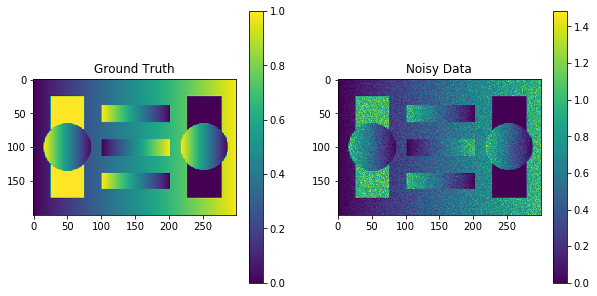

In [29]:
#loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
loader = TestData()
data = loader.load(TestData.SHAPES)
ig = data.geometry
ag = ig

# Create noisy data. 
noise = noises[which_noise]
if noise == 's&p':
    n1 = TestData.random_noise(data.as_array(), mode = noise, salt_vs_pepper = 0.9, amount=0.2)
elif noise == 'poisson':
    scale = 5
    n1 = TestData.random_noise( data.as_array()/scale, mode = noise, seed = 10)*scale
elif noise == 'gaussian':
    n1 = TestData.random_noise(data.as_array(), mode = noise, seed = 10)
else:
    raise ValueError('Unsupported Noise ', noise)
noisy_data = ig.allocate()
noisy_data.fill(n1)

# Show Ground Truth and Noisy Data
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.show()

In [30]:
# Regularisation Parameter depending on the noise distribution
if noise == 's&p':
    alpha = 0.8
elif noise == 'poisson':
    alpha = 1
elif noise == 'gaussian':
    alpha = .3

# fidelity
if noise == 's&p':
    f2 = L1Norm(b=noisy_data)
elif noise == 'poisson':
    f2 = KullbackLeibler(noisy_data)
elif noise == 'gaussian':
    f2 = 0.5 * L2NormSquared(b=noisy_data)

if method == '0':

    # Create operators
    op1 = Gradient(ig, correlation=Gradient.CORRELATION_SPACE)
    op2 = Identity(ig, ag)

    # Create BlockOperator
    operator = BlockOperator(op1, op2, shape=(2,1) ) 

    # Create functions      
    f = BlockFunction(alpha * MixedL21Norm(), f2) 
    g = ZeroFunction()
    
else:
    
    operator = Gradient(ig)
    f =  alpha * MixedL21Norm()
    g = f2
    


In [31]:
# Compute operator Norm
normK = operator.norm()

# Primal & dual stepsizes
sigma = 1
tau = 1/(sigma*normK**2)

import time


t = time.time()
# Setup and run the PDHG algorithm
pdhg = PDHG(f=f,g=g,operator=operator, tau=tau, sigma=sigma)
pdhg.max_iteration = 10000
pdhg.update_objective_interval = 1000
pdhg.run(10000)
pdhg.update_objective()
print ("Framework: ", (time.time()-t), pdhg.get_last_objective())

Calling from creator
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0      10000         0.000    4.92054e+04  -8.93891e+03    5.81443e+04
     1000      10000         0.002    1.63757e+03   1.63667e+03    8.94081e-01
     2000      10000         0.002    1.63712e+03   1.63688e+03    2.38179e-01
     3000      10000         0.002    1.63703e+03   1.63691e+03    1.19379e-01
     4000      10000         0.002    1.63699e+03   1.63691e+03    7.70208e-02
     5000      10000         0.002    1.63697e+03   1.63692e+03    5.72353e-02
     6000      10000         0.002    1.63696e+03   1.63692e+03    4.44923e-02
     7000      10000         0.002    1.63696e+03   1.63692e+03    3.67788e-02
     8000      10000         0.002    1.63695e+03   1.63692e+03    3.12013e-02
     9000      10000         0.002    1.63695e+03   1.63692e+03    2.71806e-02
Framework:  24.662771224975586 

In [32]:
def objective (x, f=f, g=g, operator=operator):
    return f(operator.direct(x)) + g(x)

print ("running regularisers")
os.environ['OMP_NUM_THREADS'] = '8'
t = time.time()
reg = FGP_TV(alpha, pdhg.max_iteration, 1e-7, 0, 0, 0, 'gpu')
a = reg.proximal(noisy_data, 1. )
t_reg = (time.time()-t)
print ("Regularisation: ", t_reg, objective(a))

running regularisers
Regularisation:  3.0634572505950928 2220.016845703125


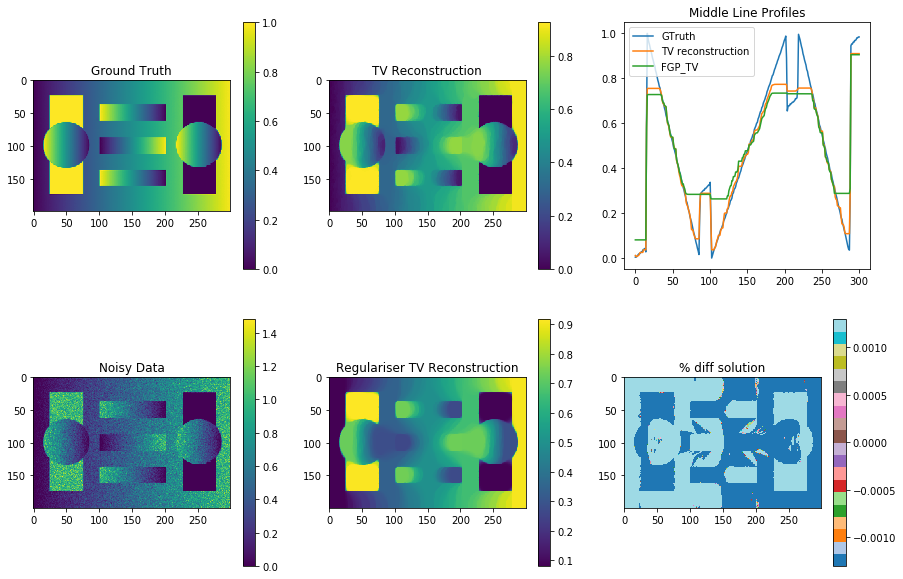

In [33]:
# Show results
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(data.subset(channel=0).as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(noisy_data.subset(channel=0).as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(pdhg.get_output().subset(channel=0).as_array())
plt.title('TV Reconstruction')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(a.subset(channel=0).as_array())
plt.title('Regulariser TV Reconstruction')
plt.colorbar()
plt.subplot(2,3,3)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), a.as_array()[int(ig.shape[0]/2),:], label = 'FGP_TV')
plt.legend()
plt.title('Middle Line Profiles')
plt.subplot(2,3,6)
plt.imshow(((a-pdhg.get_output())/a).subset(channel=0).as_array(),cmap='tab20')
plt.clim([-0.0013,.0013])
plt.title('% diff solution')
plt.colorbar()
plt.show()

----------------------------------------------------------------------------
	SCS v2.1.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 359002
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 120001, constraints m = 240003
Cones:	linear vars: 1
	soc vars: 240002, soc blks: 60001
Setup time: 3.22e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.74e+21  5.23e+21  1.00e+00 -2.79e+25  1.14e+24  6.44e+24  4.39e-02 
   100| 3.64e-04  1.03e-03  9.65e-04  5.54e+02  5.53e+02  2.30e-13  6.05e+00 
   200| 4.41e-05  1.15e-04  1.96e-05  5.53e+02  5.53e+02  7.80e-13  1.16e+01 
   300

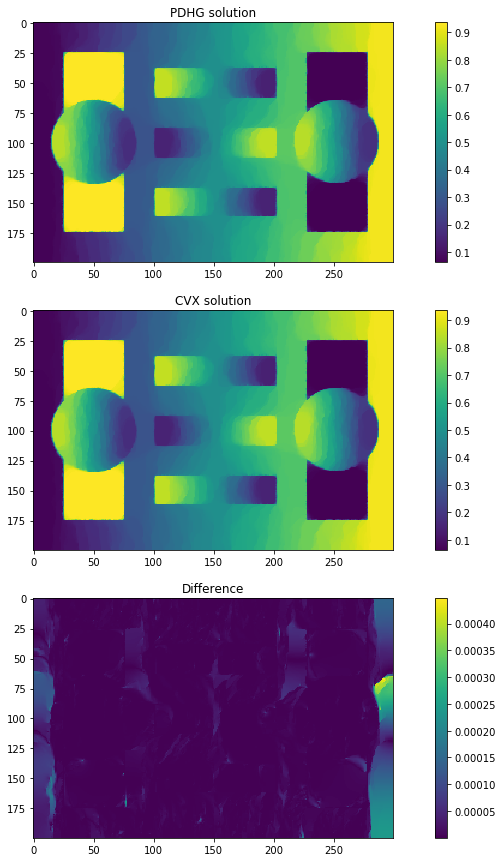

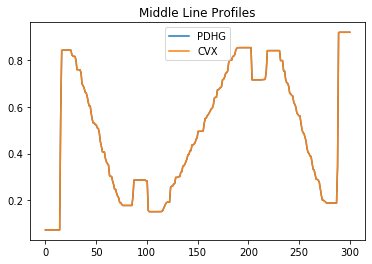

Primal Objective (CVX) 553.0904028754609 
Primal Objective (PDHG) 553.0875762939453 


In [9]:
#%% Check with CVX solution

from ccpi.optimisation.operators import SparseFiniteDiff

try:
    from cvxpy import *

    cvx_installable = True
except ImportError:
    cvx_installable = False

if not cvx_installable:
    print("Install CVXPY module to compare with CVX solution")
else:

    ##Construct problem
    u = Variable(ig.shape)
    
    DY = SparseFiniteDiff(ig, direction=0, bnd_cond='Neumann')
    DX = SparseFiniteDiff(ig, direction=1, bnd_cond='Neumann')
    
    # Define Total Variation as a regulariser
    regulariser = alpha * sum(norm(vstack([Constant(DX.matrix()) * vec(u), Constant(DY.matrix()) * vec(u)]), 2, axis = 0))
    
    # choose solver
    if 'MOSEK' in installed_solvers():
        solver = MOSEK
    else:
        solver = SCS      

    # fidelity
    if noise == 's&p':
        fidelity = pnorm( u - noisy_data.as_array(),1)
    elif noise == 'poisson':
        fidelity = sum(kl_div(noisy_data.as_array(), u)) 
        solver = SCS
    elif noise == 'gaussian':
        fidelity = 0.5 * sum_squares(noisy_data.as_array() - u)
                
    obj =  Minimize( regulariser +  fidelity)
    prob = Problem(obj)
    result = prob.solve(verbose = True, solver = solver)
    
    diff_cvx = numpy.abs( pdhg.get_output().as_array() - u.value )
        
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.imshow(pdhg.get_output().as_array())
    plt.title('PDHG solution')
    plt.colorbar()
    plt.subplot(3,1,2)
    plt.imshow(u.value)
    plt.title('CVX solution')
    plt.colorbar()
    plt.subplot(3,1,3)
    plt.imshow(diff_cvx)
    plt.title('Difference')
    plt.colorbar()
    plt.show()    
    
    plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'PDHG')
    plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), u.value[int(ig.shape[0]/2),:], label = 'CVX')
    plt.legend()
    plt.title('Middle Line Profiles')
    plt.show()
            
    print('Primal Objective (CVX) {} '.format(obj.value))
    print('Primal Objective (PDHG) {} '.format(pdhg.objective[-1][0]))
